# Weather Typing

## Predictor - Load large scale atmospheric variables

### mean sea level pressure, spatial gradient of mean sea level pressure

In [1]:
from utils.data import load_atmospheric_predictor

# Define the variables and region
variables = ["msl", "msl_gradient"]
region = (200, -10, 360, 80)
estela = True

# Load the ERA5 dynamic predictors
era5_dynamic = load_atmospheric_predictor(
    variables=variables, region=region, estela=estela
)
era5_dynamic

<xarray.Dataset> Size: 145MB
Dimensions:       (time: 19684, latitude: 23, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 92B 79.62 75.62 71.62 ... -4.375 -8.375
  * time          (time) datetime64[s] 157kB 1970-01-01 ... 2023-11-22
  * longitude     (longitude) float32 160B 200.4 204.4 208.4 ... 352.4 356.4
Data variables:
    msl           (time, latitude, longitude) float32 72MB nan nan ... nan nan
    msl_gradient  (time, latitude, longitude) float32 72MB nan nan ... nan nan

## Predictor - Define weather types

### PCA + KMA

In [2]:
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.datamining.kma import KMA
from bluemath_tk.predictor.xwt import XWT

pca = PCA(n_components=0.9)
kma = KMA(num_clusters=36, seed=42)

xwt = XWT(steps={"pca": pca, "kma": kma})
xwt.fit(
    data=era5_dynamic,
    fit_params={
        "pca": {
            "vars_to_stack": variables,
            "coords_to_stack": ["latitude", "longitude"],
            "pca_dim_for_rows": "time",
            "value_to_replace_nans": {"msl": 101325.0, "msl_gradient": 0.0},
        },
        "kma": {
            "normalize_data": False,
            "min_number_of_points": 50,
            "max_number_of_iterations": 100,
        },
    },
    variable_to_sort_bmus="msl",
)
xwt.save_model("outputs/dwt_model_aveiro.pkl")

2025-05-23 11:08:15,612 - PCA - WARNING - Data contains NaNs.


2025-05-23 11:08:15,704 - PCA - WARNING - Data contains NaNs.



        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.9
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


2025-05-23 11:08:25,852 - PCA - WARNING - Attribute pcs is an xarray Dataset / Dataarray and will be pickled!


## Predictor - Describe Weather Types

### Plotting + Statistics

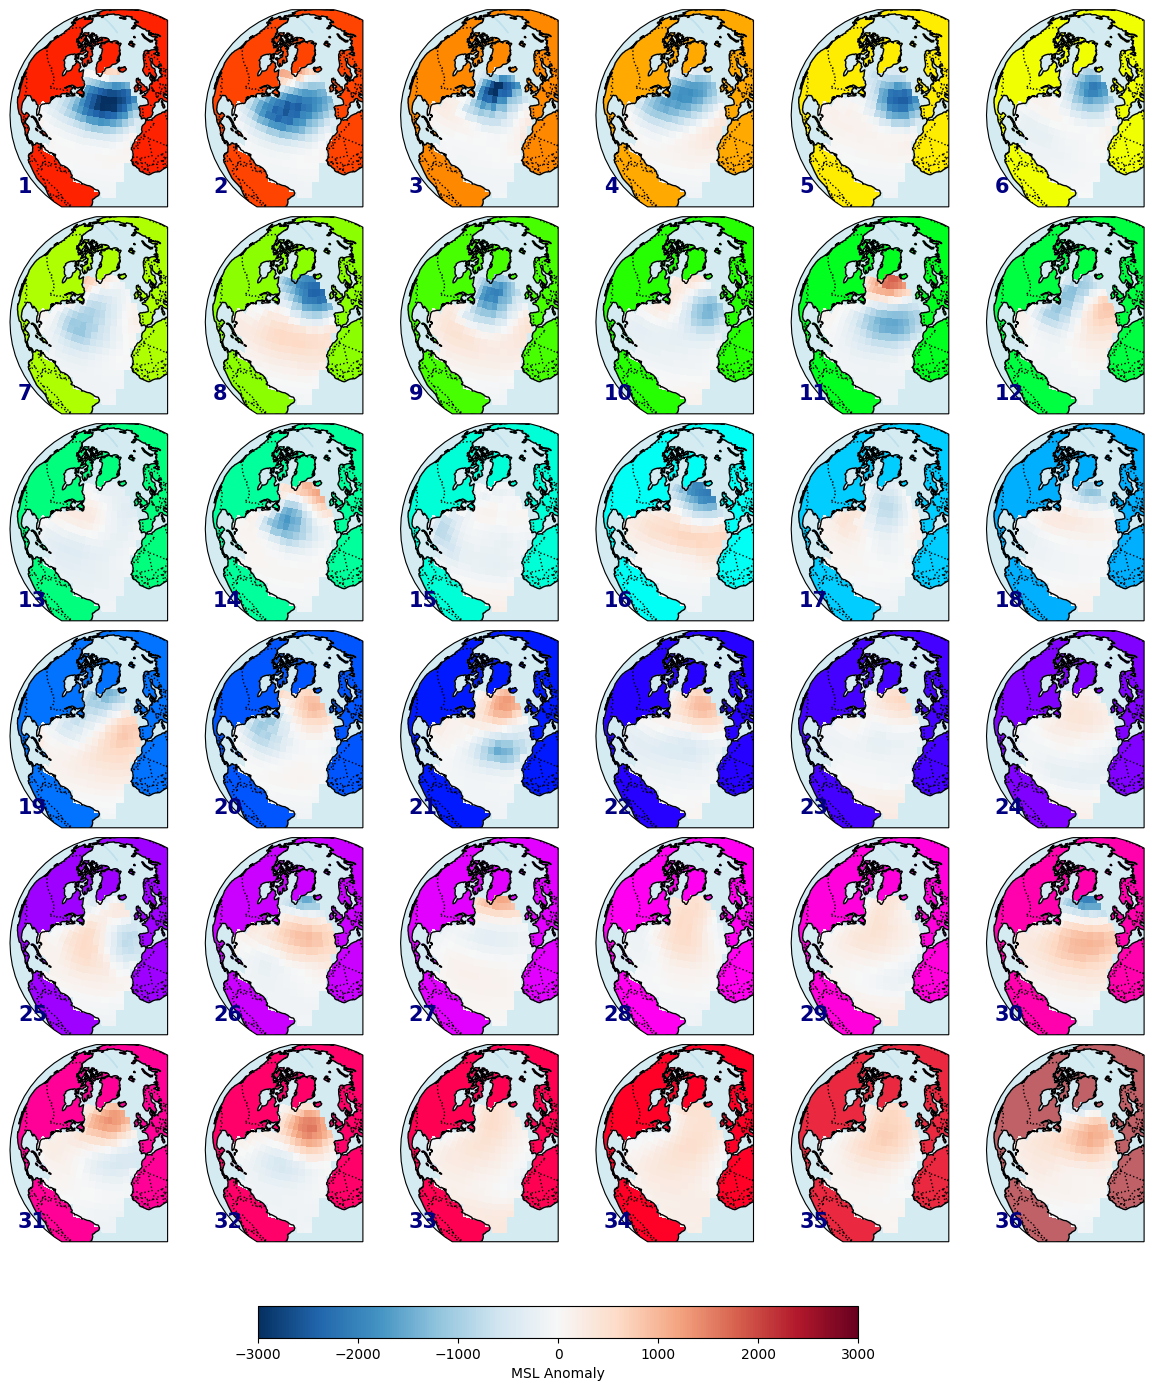

In [3]:
from bluemath_tk.predictor.xwt import config_variables

config_variables["msl"] = {
    "vmin": -3000,
    "vmax": 3000,
    "label": "MSL Anomaly",
}
xwt.plot_xwts(var_to_plot="msl", anomaly=True, map_center=(-25, 40))

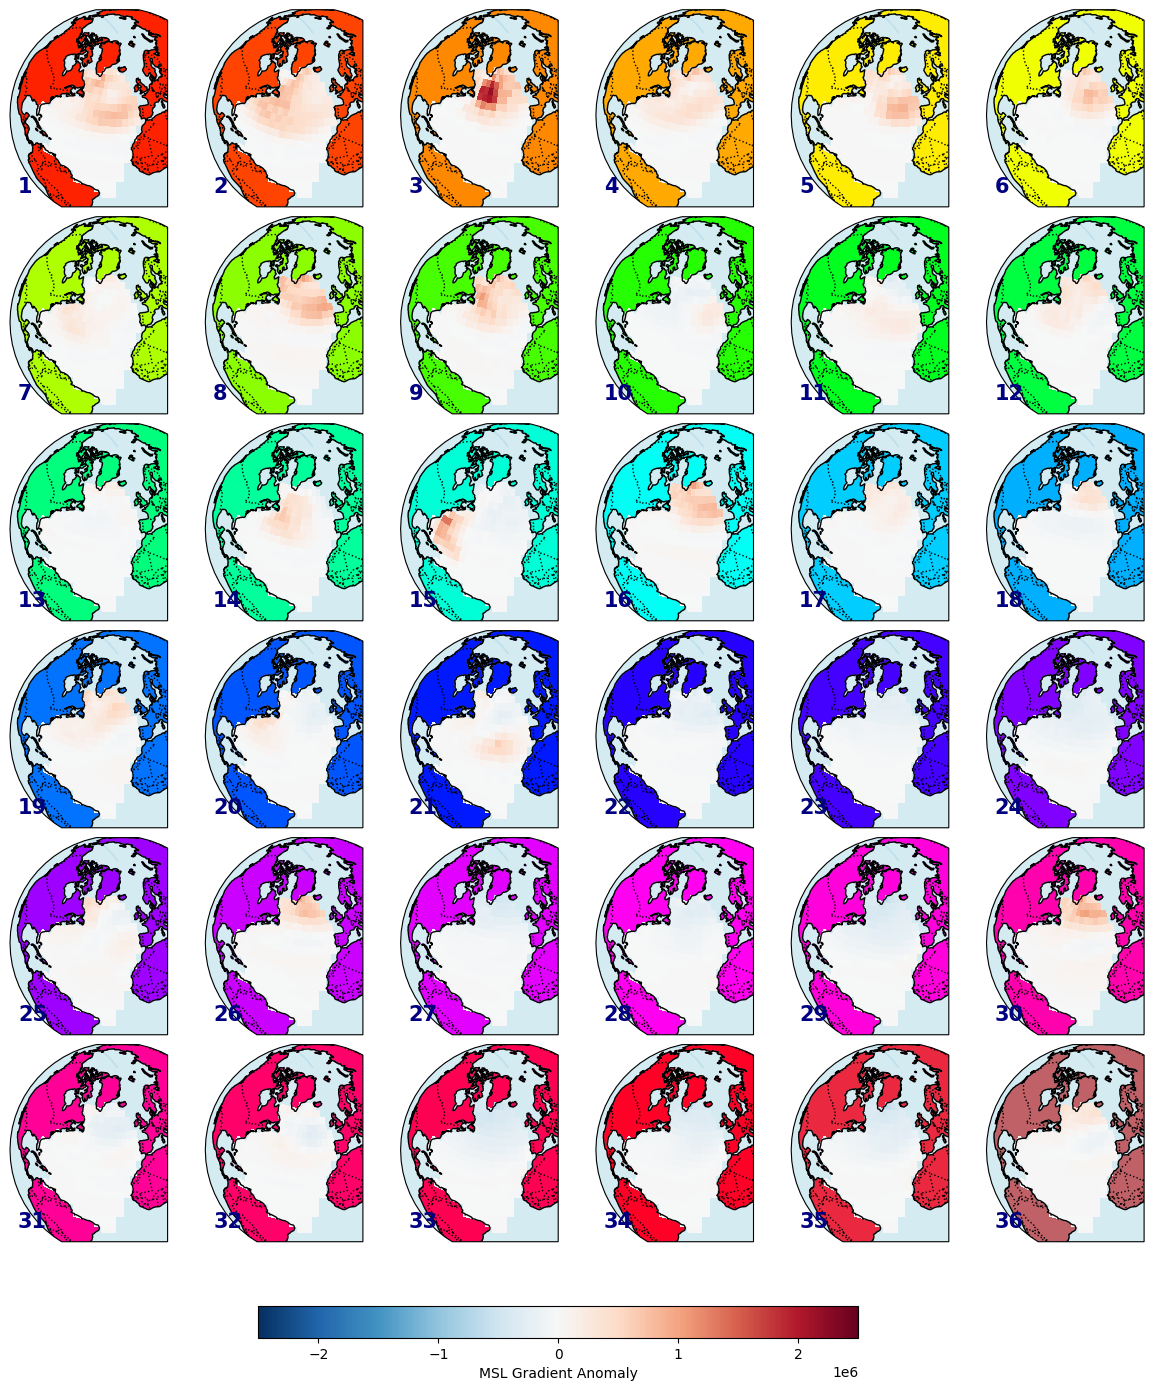

In [4]:
from bluemath_tk.predictor.xwt import config_variables

config_variables["msl_gradient"] = {
    "vmin": -2.5 * 1e6,
    "vmax": 2.5 * 1e6,
    "label": "MSL Gradient Anomaly",
}
xwt.plot_xwts(var_to_plot="msl_gradient", anomaly=True, map_center=(-25, 40))

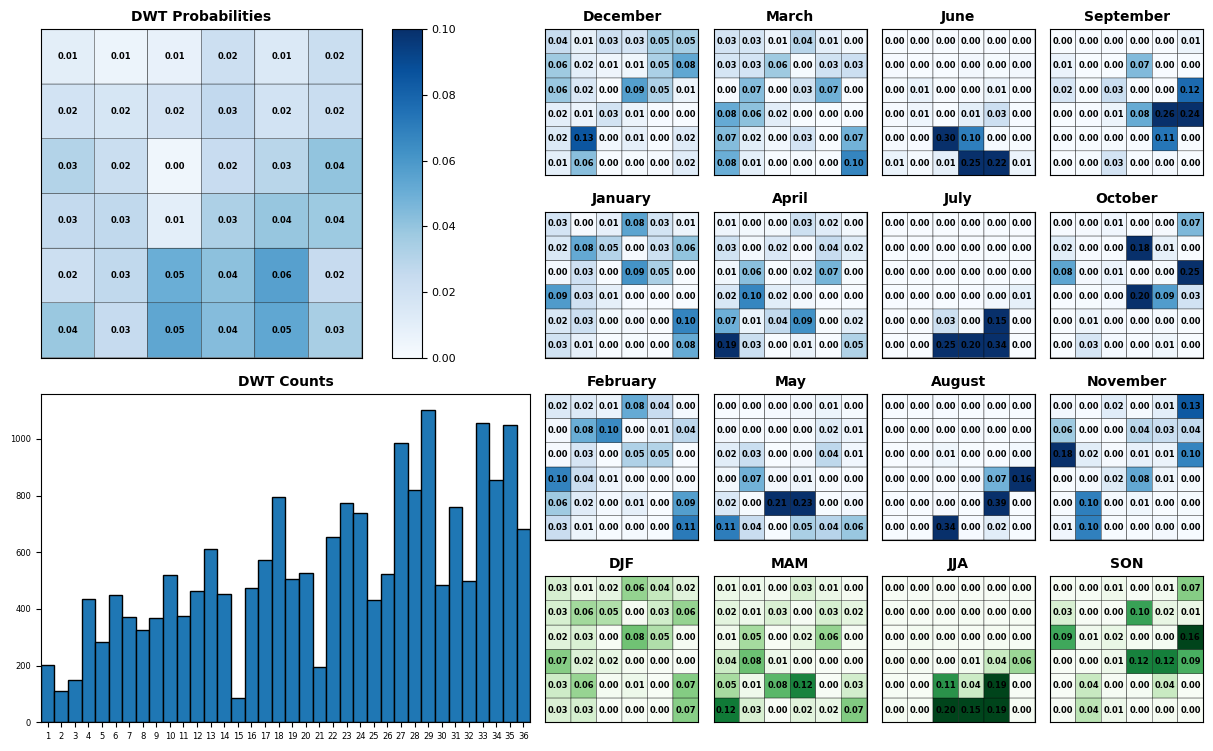

In [5]:
xwt.plot_dwts_probs(plot_text=True)

<Axes: >

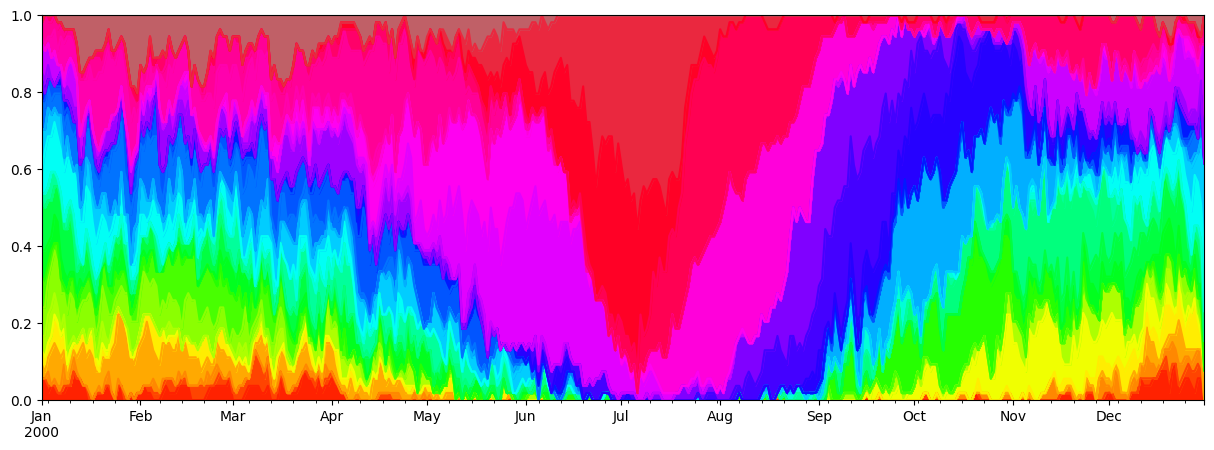

In [6]:
xwt.plot_perpetual_year()

## Predictand - Load regional/local wave data

### significant wave height, peak period, mean wave direction

In [7]:
import xarray as xr

waves = (
    xr.open_dataset("data/era5_aveiro_daily.nc")
    .sel(time=xwt.kma_bmus.index, method="nearest", tolerance="1H")
)
waves["kma_bmus"] = (("time"), xwt.kma_bmus.kma_bmus.values)
waves

<xarray.Dataset> Size: 551kB
Dimensions:    (time: 19684)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
Data variables:
    swh        (time) float64 157kB ...
    EF         (time) float64 157kB ...
    kma_bmus   (time) int32 79kB 22 10 10 11 11 21 21 2 ... 18 18 10 10 14 32 32
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-24 23:51:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Predictand to Predictor - Model

### Empirical distribution of wave parameters conditioned to each weather type

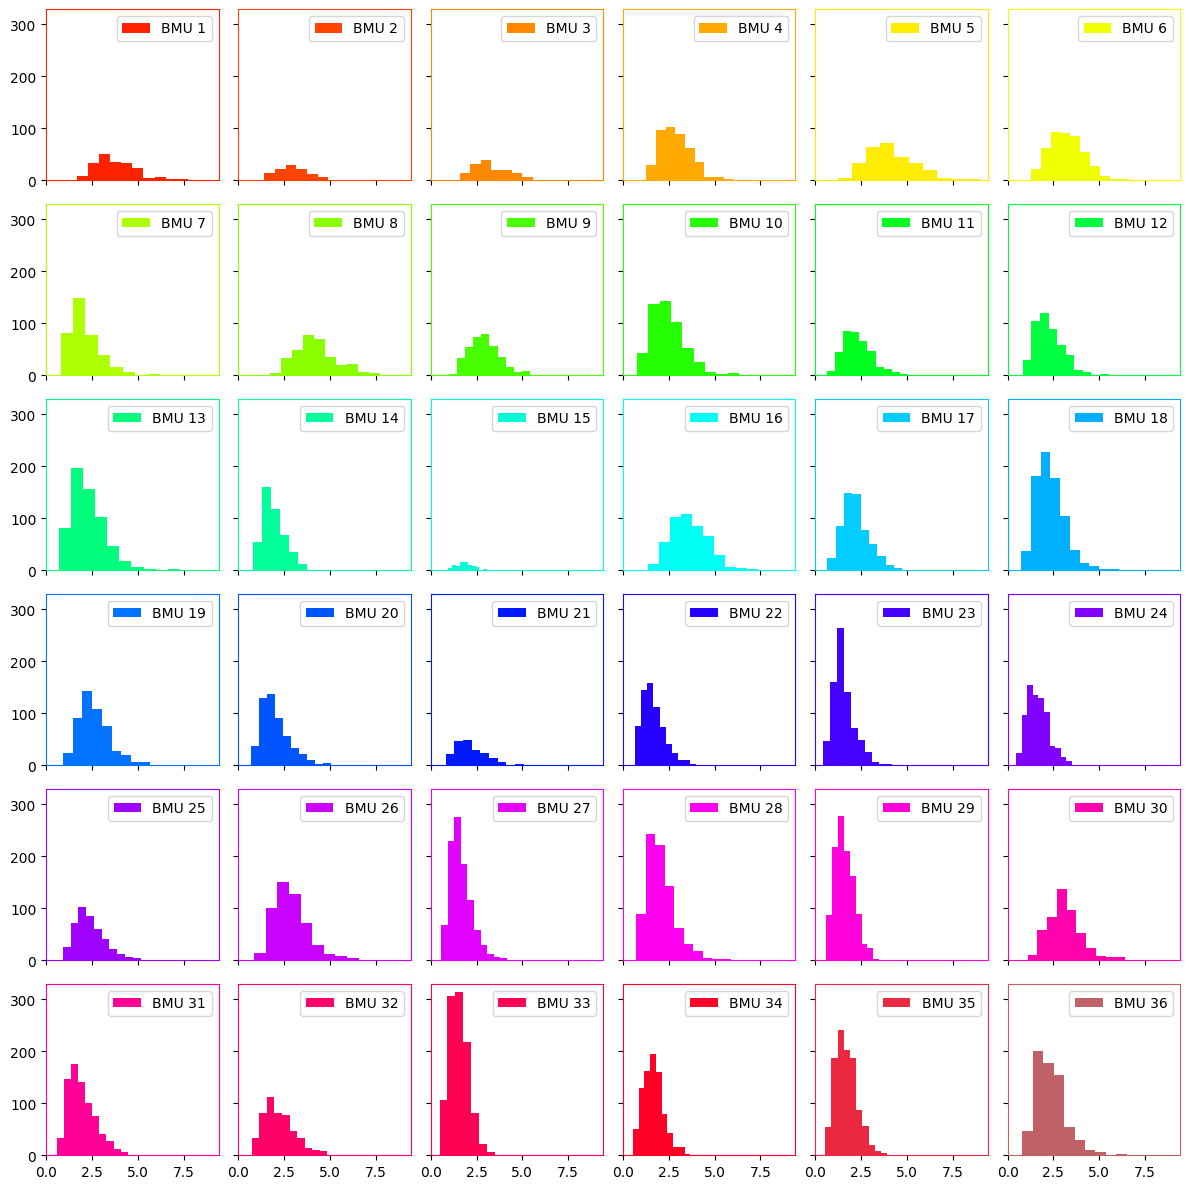

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from bluemath_tk.core.plotting.colors import get_cluster_colors

wave_variable = "swh"

cluster_colors = get_cluster_colors(xwt.num_clusters)
fig, axes = plt.subplots(6, 6, figsize=(12, 12), sharex=True, sharey=True)
for ax, kma_bmus_index, color in zip(axes.flatten(), range(1, 37), cluster_colors):
    bmus_indexes = np.where(waves["kma_bmus"].values == kma_bmus_index)[0]
    try:
        waves[wave_variable].isel(time=bmus_indexes).squeeze().plot.hist(
            ax=ax, color=color, label=f"BMU {kma_bmus_index}"
        )
        ax.legend()
        ax.set_title("")
        ax.set_xlabel("")
        for border in ["top", "bottom", "left", "right"]:
            ax.spines[border].set_color(color)
    except:
        pass
plt.tight_layout()